In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:

def load_data():
    ratings = pd.read_csv('Dataset/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv('Dataset/ml-100k/u.item', sep='|', encoding='latin-1', 
                        names=['movie_id', 'title'] + [f'col_{i}' for i in range(22)], usecols=['movie_id', 'title'])
    return ratings, movies

In [3]:
# Create user-item matrix
def create_user_item_matrix(ratings):
    user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    return user_item_matrix

In [4]:
# Compute user similarity
def compute_user_similarity(user_item_matrix):
    user_similarity = cosine_similarity(user_item_matrix)
    return user_similarity


In [5]:
# Recommend movies for a user
def recommend_movies(user_id, user_item_matrix, user_similarity, movies, n=5):
    user_idx = user_item_matrix.index.get_loc(user_id)
    sim_scores = user_similarity[user_idx]
    similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself
    
    # Get movies the user hasn't rated
    user_ratings = user_item_matrix.iloc[user_idx]
    unrated_movies = user_ratings[user_ratings == 0].index
    
    # Aggregate ratings from similar users
    movie_scores = {}
    for movie in unrated_movies:
        movie_ratings = user_item_matrix.loc[:, movie]
        sim_sum = 0
        weighted_sum = 0
        for sim_user_idx in similar_users[:10]:  # Top 10 similar users
            if movie_ratings.iloc[sim_user_idx] > 0:
                weighted_sum += sim_scores[sim_user_idx] * movie_ratings.iloc[sim_user_idx]
                sim_sum += sim_scores[sim_user_idx]
        if sim_sum > 0:
            movie_scores[movie] = weighted_sum / sim_sum
    
    # Sort and get top N recommendations
    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    recommended_titles = [(movies[movies['movie_id'] == movie_id]['title'].iloc[0], score) 
                         for movie_id, score in top_movies]
    return recommended_titles


In [6]:
# Evaluate precision at K
def precision_at_k(user_id, user_item_matrix, user_similarity, movies, k=5):
    # Split data for evaluation
    train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
    train_matrix = create_user_item_matrix(train_ratings)
    
    # Get recommendations
    recommendations = recommend_movies(user_id, train_matrix, compute_user_similarity(train_matrix), movies, k)
    recommended_movie_ids = [movies[movies['title'] == rec[0]]['movie_id'].iloc[0] for rec in recommendations]
    
    # Get actual liked movies (rating >= 4) from test set
    test_user_ratings = test_ratings[test_ratings['user_id'] == user_id]
    actual_liked = test_user_ratings[test_user_ratings['rating'] >= 4]['movie_id'].tolist()
    
    # Calculate precision
    hits = len(set(recommended_movie_ids) & set(actual_liked))
    return hits / k if k > 0 else 0


In [7]:
# Item-based collaborative filtering
def recommend_movies_item_based(user_id, user_item_matrix, movies, n=5):
    item_similarity = cosine_similarity(user_item_matrix.T)
    user_ratings = user_item_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index
    
    movie_scores = {}
    for movie in unrated_movies:
        movie_idx = user_item_matrix.columns.get_loc(movie)
        sim_scores = item_similarity[movie_idx]
        rated_movies = user_ratings[user_ratings > 0].index
        score = 0
        sim_sum = 0
        for rated_movie in rated_movies:
            rated_movie_idx = user_item_matrix.columns.get_loc(rated_movie)
            score += sim_scores[rated_movie_idx] * user_ratings[rated_movie]
            sim_sum += sim_scores[rated_movie_idx]
        if sim_sum > 0:
            movie_scores[movie] = score / sim_sum
    
    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    recommended_titles = [(movies[movies['movie_id'] == movie_id]['title'].iloc[0], score) 
                         for movie_id, score in top_movies]
    return recommended_titles


In [8]:
ratings, movies = load_data()
user_item_matrix = create_user_item_matrix(ratings)
user_similarity = compute_user_similarity(user_item_matrix)

In [9]:
user_id = 1
print(f"User-based recommendations for user {user_id}:")
recommendations = recommend_movies(user_id, user_item_matrix, user_similarity, movies)
for title, score in recommendations:
    print(f"{title}: {score:.2f}")
    
print(f"\nItem-based recommendations for user {user_id}:")
item_recommendations = recommend_movies_item_based(user_id, user_item_matrix, movies)
for title, score in item_recommendations:
    print(f"{title}: {score:.2f}")
    
# Evaluate
precision = precision_at_k(user_id, user_item_matrix, user_similarity, movies)
print(f"\nPrecision at 5 for user {user_id}: {precision:.2f}")

User-based recommendations for user 1:
Casablanca (1942): 5.00
Secrets & Lies (1996): 5.00
Wings of Desire (1987): 5.00
Walk in the Clouds, A (1995): 5.00
American in Paris, An (1951): 5.00

Item-based recommendations for user 1:
Cyclo (1995): 4.38
Office Killer (1997): 4.24
Little City (1998): 4.23
Death in Brunswick (1991): 4.22
Mamma Roma (1962): 4.18

Precision at 5 for user 1: 0.20


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load Data
def load_data():
    ratings = pd.read_csv('Dataset/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv('Dataset/ml-100k/u.item', sep='|', encoding='latin-1', 
                        names=['movie_id', 'title'] + [f'col_{i}' for i in range(22)], usecols=['movie_id', 'title'])
    return ratings, movies

In [12]:
# Create user-item matrix
def create_user_item_matrix(ratings):
    user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    return user_item_matrix

In [13]:
# Compute user similarity
def compute_user_similarity(user_item_matrix):
    user_similarity = cosine_similarity(user_item_matrix)
    return user_similarity

In [14]:
# Recommend movies for a user (user-based collaborative filtering)
def recommend_movies(user_id, user_item_matrix, user_similarity, movies, n=5):
    user_idx = user_item_matrix.index.get_loc(user_id)
    sim_scores = user_similarity[user_idx]
    similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself
    
    # Get movies the user hasn't rated
    user_ratings = user_item_matrix.iloc[user_idx]
    unrated_movies = user_ratings[user_ratings == 0].index
    
    # Aggregate ratings from similar users
    movie_scores = {}
    for movie in unrated_movies:
        movie_ratings = user_item_matrix.loc[:, movie]
        sim_sum = 0
        weighted_sum = 0
        for sim_user_idx in similar_users[:10]:  # Top 10 similar users
            if movie_ratings.iloc[sim_user_idx] > 0:
                weighted_sum += sim_scores[sim_user_idx] * movie_ratings.iloc[sim_user_idx]
                sim_sum += sim_scores[sim_user_idx]
        if sim_sum > 0:
            movie_scores[movie] = weighted_sum / sim_sum
    
    # Sort and get top N recommendations
    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    recommended_titles = [(movies[movies['movie_id'] == movie_id]['title'].iloc[0], score) 
                         for movie_id, score in top_movies]
    return recommended_titles

In [15]:
# SVD-based recommendation
def recommend_movies_svd(user_id, user_item_matrix, movies, n=5, n_components=50):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    latent_matrix = svd.fit_transform(user_item_matrix)
    movie_latent_matrix = svd.components_.T
    
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_latent = latent_matrix[user_idx]
    predicted_ratings = np.dot(user_latent, movie_latent_matrix.T)
    
    user_ratings = user_item_matrix.iloc[user_idx]
    unrated_movies = user_ratings[user_ratings == 0].index
    
    movie_scores = {movie: predicted_ratings[user_item_matrix.columns.get_loc(movie)] 
                    for movie in unrated_movies}
    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    recommended_titles = [(movies[movies['movie_id'] == movie_id]['title'].iloc[0], score) 
                         for movie_id, score in top_movies]
    return recommended_titles, movie_latent_matrix

In [16]:
# Item-based collaborative filtering
def recommend_movies_item_based(user_id, user_item_matrix, movies, n=5):
    item_similarity = cosine_similarity(user_item_matrix.T)
    user_ratings = user_item_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index
    
    movie_scores = {}
    for movie in unrated_movies:
        movie_idx = user_item_matrix.columns.get_loc(movie)
        sim_scores = item_similarity[movie_idx]
        rated_movies = user_ratings[user_ratings > 0].index
        score = 0
        sim_sum = 0
        for rated_movie in rated_movies:
            rated_movie_idx = user_item_matrix.columns.get_loc(rated_movie)
            score += sim_scores[rated_movie_idx] * user_ratings[rated_movie]
            sim_sum += sim_scores[rated_movie_idx]
        if sim_sum > 0:
            movie_scores[movie] = score / sim_sum
    
    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    recommended_titles = [(movies[movies['movie_id'] == movie_id]['title'].iloc[0], score) 
                         for movie_id, score in top_movies]
    return recommended_titles

In [17]:
# Evaluate precision at K
def precision_at_k(user_id, user_item_matrix, user_similarity, movies, k=5):
    train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
    train_matrix = create_user_item_matrix(train_ratings)
    
    recommendations = recommend_movies(user_id, train_matrix, compute_user_similarity(train_matrix), movies, k)
    recommended_movie_ids = [movies[movies['title'] == rec[0]]['movie_id'].iloc[0] for rec in recommendations]
    
    test_user_ratings = test_ratings[test_ratings['user_id'] == user_id]
    actual_liked = test_user_ratings[test_user_ratings['rating'] >= 4]['movie_id'].tolist()
    
    hits = len(set(recommended_movie_ids) & set(actual_liked))
    return hits / k if k > 0 else 0

In [18]:
ratings, movies = load_data()
user_item_matrix = create_user_item_matrix(ratings)
user_similarity = compute_user_similarity(user_item_matrix)

In [19]:
user_id = 1
print(f"User-based recommendations for user {user_id}:")
user_recs = recommend_movies(user_id, user_item_matrix, user_similarity, movies)
for title, score in user_recs:
    print(f"{title}: {score:.2f}")

User-based recommendations for user 1:
Casablanca (1942): 5.00
Secrets & Lies (1996): 5.00
Wings of Desire (1987): 5.00
Walk in the Clouds, A (1995): 5.00
American in Paris, An (1951): 5.00


In [20]:
print(f"\nItem-based recommendations for user {user_id}:")
item_recs = recommend_movies_item_based(user_id, user_item_matrix, movies)
for title, score in item_recs:
    print(f"{title}: {score:.2f}")


Item-based recommendations for user 1:
Cyclo (1995): 4.38
Office Killer (1997): 4.24
Little City (1998): 4.23
Death in Brunswick (1991): 4.22
Mamma Roma (1962): 4.18


In [21]:
print(f"\nSVD-based recommendations for user {user_id}:")
svd_recs, _ = recommend_movies_svd(user_id, user_item_matrix, movies)
for title, score in svd_recs:
    print(f"{title}: {score:.2f}")


SVD-based recommendations for user 1:
Schindler's List (1993): 3.38
True Lies (1994): 3.24
E.T. the Extra-Terrestrial (1982): 2.91
Dave (1993): 2.87
Heat (1995): 2.84


In [22]:
precision = precision_at_k(user_id, user_item_matrix, user_similarity, movies)
print(f"\nPrecision@5 for user {user_id} (user-based): {precision:.2f}")


Precision@5 for user 1 (user-based): 0.20


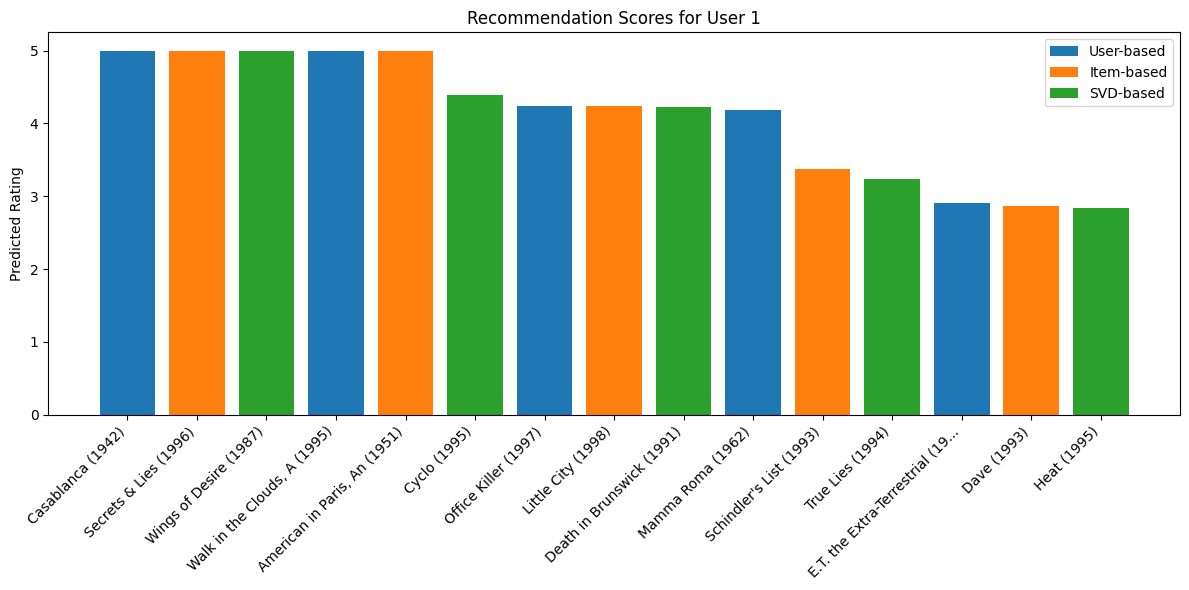

In [23]:
plt.figure(figsize=(12, 6))

# Prepare data for bar chart
methods = ['User-based', 'Item-based', 'SVD-based']
all_recs = [user_recs, item_recs, svd_recs]
titles = []
scores = []
method_labels = []

for i, recs in enumerate(all_recs):
    for title, score in recs:
        titles.append(title[:30] + '...' if len(title) > 30 else title)
        scores.append(score)
        method_labels.append(methods[i])

# Bar chart
x = np.arange(len(titles))
plt.bar(x, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'] * len(user_recs))
plt.xticks(x, titles, rotation=45, ha='right')
plt.ylabel('Predicted Rating')
plt.title(f'Recommendation Scores for User {user_id}')
plt.legend([plt.Rectangle((0,0),1,1,fc='#1f77b4'), 
            plt.Rectangle((0,0),1,1,fc='#ff7f0e'), 
            plt.Rectangle((0,0),1,1,fc='#2ca02c')], methods)
plt.tight_layout()
plt.savefig('recommendation_scores.png')
plt.show()

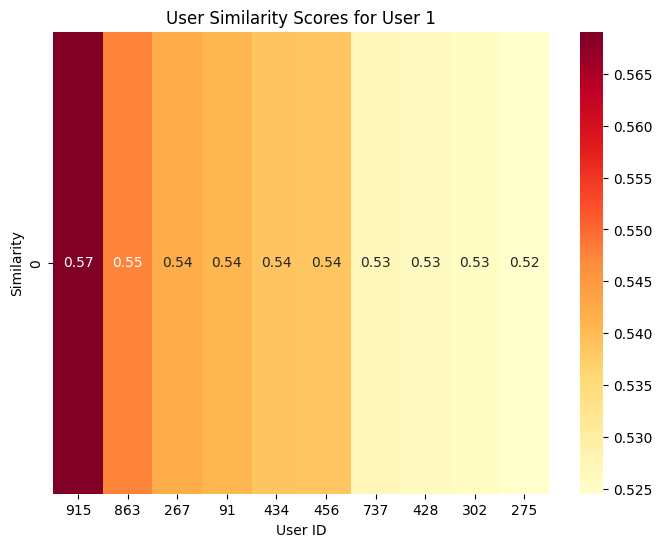

In [24]:
user_idx = user_item_matrix.index.get_loc(user_id)
top_similar = np.argsort(user_similarity[user_idx])[::-1][1:11]  # Top 10 similar users
sim_scores = user_similarity[user_idx][top_similar]

plt.figure(figsize=(8, 6))
sns.heatmap([sim_scores], xticklabels=top_similar, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title(f'User Similarity Scores for User {user_id}')
plt.xlabel('User ID')
plt.ylabel('Similarity')
plt.savefig('user_similarity_heatmap.png')
plt.show()

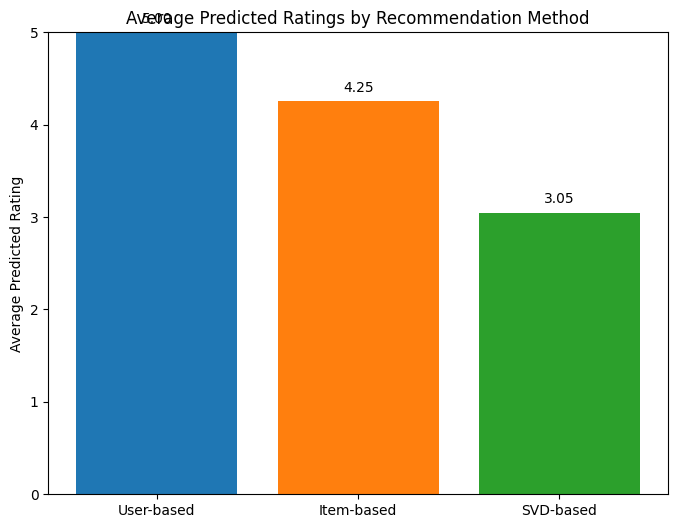

In [25]:
# Calculate average predicted rating per method
methods = ['User-based', 'Item-based', 'SVD-based']
avg_scores = []
for recs in [user_recs, item_recs, svd_recs]:
    avg_scores.append(np.mean([score for _, score in recs]) if recs else 0)

plt.figure(figsize=(8, 6))
plt.bar(methods, avg_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Average Predicted Rating')
plt.title('Average Predicted Ratings by Recommendation Method')
plt.ylim(0, 5)  # Assuming ratings are on a 0-5 scale
for i, v in enumerate(avg_scores):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.savefig('avg_rating_comparison.png')
plt.show()